In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
torch.__version__

'2.5.1+cu124'

In [3]:
device

'cuda'

In [4]:
# TO Download the COCO dataset

# from fastai.data.external import untar_data, URLs

# coco_path = untar_data(URLs.COCO_SAMPLE)

# # Append the train_sample directory
# coco_path = os.path.join(coco_path, "train_sample")

# print(f"Dataset downloaded to: {coco_path}")


In [5]:
# path="./coco_sample/coco_sample/train_sample"
path="./coco_sample/train_sample"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
paths_subset = np.random.choice(paths,10000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


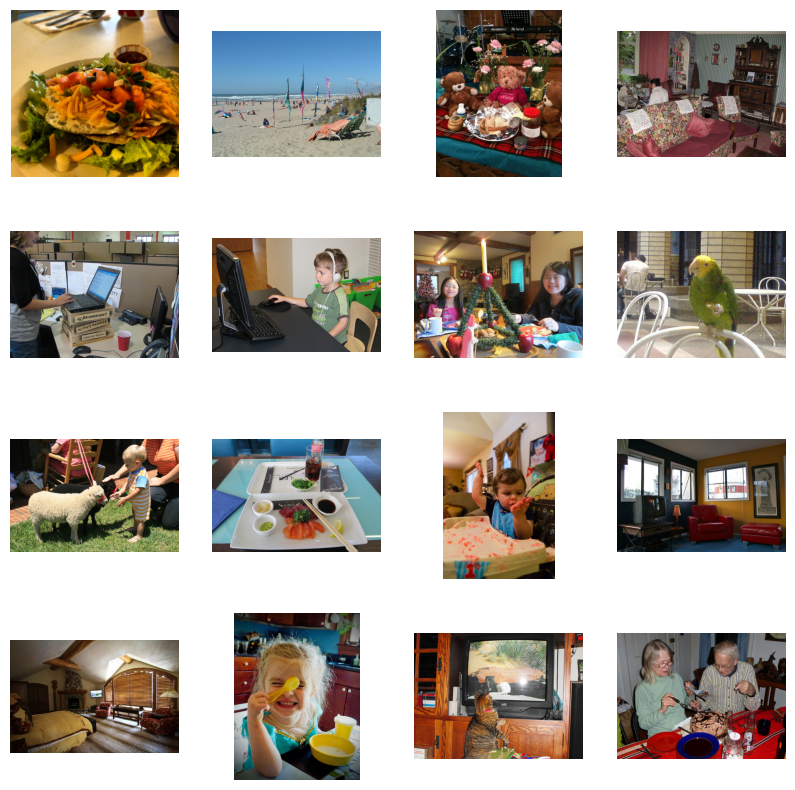

In [6]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [7]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1 , 
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)


In [8]:
def make_dataloaders(batch_size=32, n_workers=2, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, # num_workers=n_workers,## suffle could be added
                            pin_memory=pin_memory)
    return dataloader

In [9]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(f"size of train dataloader:{len(train_dl)}\nsize of validation dataloader: {len(val_dl)}")

torch.Size([32, 1, 256, 256]) torch.Size([32, 2, 256, 256])
size of train dataloader:250
size of validation dataloader: 63


In [10]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [11]:
from torchviz import make_dot
import torch

model = Unet()  # Your U-Net model
x = torch.randn(1, 1, 256, 256)  # Example input
y = model(x)

dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=False, show_saved=False)
dot.render("unet_architecture", format="png")


'unet_architecture.png'

In [12]:
model=Unet(input_c=1, output_c=2, n_down=8, num_filters=64).to(device)
from torchinfo import summary
summary(model, input_size=(16, 1, SIZE, SIZE),
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        col_width=20)

Layer (type:depth-idx)                                                                                         Input Shape          Output Shape         Param #              Kernel Shape
Unet                                                                                                           [16, 1, 256, 256]    [16, 2, 256, 256]    --                   --
├─UnetBlock: 1-1                                                                                               [16, 1, 256, 256]    [16, 2, 256, 256]    --                   --
│    └─Sequential: 2-1                                                                                         [16, 1, 256, 256]    [16, 2, 256, 256]    --                   --
│    │    └─Conv2d: 3-1                                                                                        [16, 1, 256, 256]    [16, 64, 128, 128]   1,024                [4, 4]
│    │    └─UnetBlock: 3-2                                                                           

In [13]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [14]:
from torchviz import make_dot
import torch

model = PatchDiscriminator(3)  # Your U-Net model
x = torch.randn(1, 3, 256, 256)  # Example input
y = model(x)

dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("unet_architecture", format="png")

'unet_architecture.png'

In [15]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [16]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [17]:
summary(discriminator, input_size=(16, 3, SIZE, SIZE),
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        col_width=20)
        

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Kernel Shape
PatchDiscriminator                       [16, 3, 256, 256]    [16, 1, 30, 30]      --                   --
├─Sequential: 1-1                        [16, 3, 256, 256]    [16, 1, 30, 30]      --                   --
│    └─Sequential: 2-1                   [16, 3, 256, 256]    [16, 64, 128, 128]   --                   --
│    │    └─Conv2d: 3-1                  [16, 3, 256, 256]    [16, 64, 128, 128]   3,136                [4, 4]
│    │    └─LeakyReLU: 3-2               [16, 64, 128, 128]   [16, 64, 128, 128]   --                   --
│    └─Sequential: 2-2                   [16, 64, 128, 128]   [16, 128, 64, 64]    --                   --
│    │    └─Conv2d: 3-3                  [16, 64, 128, 128]   [16, 128, 64, 64]    131,072              [4, 4]
│    │    └─BatchNorm2d: 3-4             [16, 128, 64, 64]    [16, 128, 64, 64]    256                  --
│    │    └─LeakyRe

In [18]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [19]:
import math
import torch.nn.functional as F
def calculate_psnr(img1, img2, max_pixel_value=1.0):
    mse = F.mse_loss(img1, img2)  # Compute Mean Squared Error (MSE)
    if mse == 0:
        return float('inf')  # Avoid log(0) error; perfect match case
    psnr = 10 * math.log10(max_pixel_value ** 2 / mse.item())  # Compute PSNR
    return psnr

In [20]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [21]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        real_image = torch.cat([self.L, self.ab], dim=1)
        self.psnr_value=torch.tensor(calculate_psnr(fake_image,real_image), dtype=torch.float32, device=self.device)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True) ###this time foolling desc.. by giving True
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()
  

In [22]:


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    psnr_value=AverageMeter()

    return {
        'loss_D_fake': loss_D_fake,
        'loss_D_real': loss_D_real,
        'loss_D': loss_D,
        'loss_G_GAN': loss_G_GAN,
        'loss_G_L1': loss_G_L1,
        'loss_G': loss_G,
        'psnr_value':psnr_value
    }

# Dictionary to store loss history per epoch
loss_history = {}

def update_losses(model, loss_meter_dict, epoch, count):
    if epoch not in loss_history:
        loss_history[epoch] = {}

    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

        if loss_name not in loss_history[epoch]:
            loss_history[epoch][loss_name] = []
        loss_history[epoch][loss_name].append(loss.item())

def lab_to_rgb(L, ab):
    """
    Takes a batch of images and converts them from Lab to RGB.
    """
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = [lab2rgb(img) for img in Lab]
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()

    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L

    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.set_label('GARY IMAGE')
        ax.axis("off")

        ax = plt.subplot(3, 5, i + 6)
        ax.imshow(fake_imgs[i])
        ax.axis("off")

        ax = plt.subplot(3, 5, i + 11)
        ax.imshow(real_imgs[i])
        ax.axis("off")

    plt.show()

    if save:
        fig.savefig(f"colorization_{time.time()}.png")

# def log_results(loss_meter_dict):
#     for loss_name, loss_meter in loss_meter_dict.items():
#         print(f"{loss_name}: {loss_meter.avg:.5f}")







In [26]:
# def generator_model(net_G=None):
#     if net_G is not None:
#         model = net_G
#     else:
#         model = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64))
#     return model

# def discriminator_model():
#     model = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64))
#     return model


# GANcriterion = GANLoss(gan_mode='vanilla')
# L1criterion = nn.L1Loss()

# GenModel=generator_model()
# DisModel=discriminator_model()



# lr_G=2e-4
# lr_D=2e-4
# beta1=0.5
# beta2=0.999
# lambda_L1=100.

# opt_G = optim.Adam(GenModel.parameters(), lr=lr_G, betas=(beta1, beta2))
# opt_D = optim.Adam(DisModel.parameters(), lr=lr_D, betas=(beta1, beta2))

# def set_requires_grad(self, model, requires_grad=True):
#         for p in model.parameters():
#             p.requires_grad = requires_grad

In [27]:
def train_model(model, train_dl, val_dl, epochs):
    """
    Train the model while tracking both training and validation losses.

    Parameters:
        model: The neural network model to train.
        train_dl: Dataloader for training data.
        val_dl: Dataloader for validation data.
        epochs: Number of epochs to train.
        display_every: Frequency of logging training losses.
    """
    global loss_history  # Ensure global access to loss tracking

    for e in tqdm(range(epochs)):
        # Initialize loss meters
        train_loss_meter_dict = create_loss_meters()
        val_loss_meter_dict = create_loss_meters()

        loss_history[e] = {"train": {}, "val": {}}  # Store losses for this epoch

        # **Training Phase**
        model.train()  # Set model to training mode
        for i, data in enumerate(tqdm(train_dl)):
            model.setup_input(data)
            model.optimize()

            # Update training losses
            update_losses(model, train_loss_meter_dict, epoch=e, count=data['L'].size(0))

            # Log results periodically
            # if (i + 1) % display_every == 0:
            #     print(f"\nEpoch {e+1}/{epochs} | Iteration {i+1}/{len(train_dl)}")
            #     log_results(train_loss_meter_dict)  # Print training loss

        # **Validation Phase**
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # No gradients needed for validation
            for data in tqdm(val_dl):
                model.setup_input(data)
                model.forward()  # Forward pass only, no optimization

                # Update validation losses
                update_losses(model, val_loss_meter_dict, epoch=e, count=data['L'].size(0))

        # Store averaged losses per epoch
        loss_history[e]["train"] = {loss_name: loss_meter.avg for loss_name, loss_meter in train_loss_meter_dict.items()}
        loss_history[e]["val"] = {loss_name: loss_meter.avg for loss_name, loss_meter in val_loss_meter_dict.items()}

        # Print epoch-wise loss summary
        print(f"Epoch {e+1}/{epochs} Summary:")
        print("Training Losses:")
        for key, value in loss_history[e]['train'].items():
            print(f"  {key}: {value:.4f}", end="\t\t")
        print("\n")
        print("Validation Losses:")
        for key, value in loss_history[e]['val'].items():
            print(f"  {key}: {value:.4f}" ,end="\t\t")
        print("\n")

# model = MainModel()
# train_model(model, train_dl,val_dl,3)


In [23]:
def plot_loss_curves(loss_history, epochs=20):
    loss_D_fake=[]
    loss_D_real=[]
    loss_D=[]
    loss_G_GAN=[]
    loss_G_L1=[]
    loss_G =[]

    val_loss_D_fake=[]
    val_loss_D_real=[]
    val_loss_D=[]
    val_loss_G_GAN=[]
    val_loss_G_L1=[]
    val_loss_G =[]
    for i in range(epochs):
        value=loss_history[i]['train']['loss_D_fake']
        loss_D_fake.append(value)
        loss_D_real.append(loss_history[i]['train']['loss_D_real'])
        loss_D.append(loss_history[i]['train']['loss_D'])
        loss_G_GAN.append(loss_history[i]['train']['loss_G_GAN'])
        loss_G_L1.append(loss_history[i]['train']['loss_G_L1'])
        loss_G.append(loss_history[i]['train']['loss_G'])


        val_loss_D_fake.append(loss_history[i]['val']['loss_D_fake'])
        val_loss_D_real.append(loss_history[i]['val']['loss_D_real'])
        val_loss_D.append(loss_history[i]['val']['loss_D'])
        val_loss_G_GAN.append(loss_history[i]['val']['loss_G_GAN'])
        val_loss_G_L1.append(loss_history[i]['val']['loss_G_L1'])
        val_loss_G.append(loss_history[i]['val']['loss_G'])


    # Create a figure with a specified size
    plt.figure(figsize=(15, 10))

    # Plotting each loss function in subplots
    plt.subplot(2, 3, 1)
    plt.plot(range(epochs), loss_D_fake, label="loss_D_fake")
    plt.plot(range(epochs), val_loss_D_fake, label="val_loss_D_fake")
    plt.title("Loss D Fake")
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(range(epochs), loss_D_real, label="loss_D_real")
    plt.plot(range(epochs), val_loss_D_real, label="val_loss_D_real")
    plt.title("Loss D Real")
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(range(epochs), loss_D, label="loss_D")
    plt.plot(range(epochs), val_loss_D, label="val_loss_D")
    plt.title("Loss D")
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(range(epochs), loss_G_GAN, label="loss_G_GAN")
    plt.plot(range(epochs), val_loss_G_GAN, label="val_loss_G_GAN")
    plt.title("Loss G GAN")
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(range(epochs), loss_G_L1, label="loss_G_L1")
    plt.plot(range(epochs), val_loss_G_L1, label="val_loss_G_L1")
    plt.title("Loss G L1")
    plt.legend()

    plt.subplot(2, 3, 6)
    plt.plot(range(epochs), loss_G, label="loss_G")
    plt.plot(range(epochs), val_loss_G, label="val_loss_G")
    plt.title("Loss G")
    plt.legend()

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

# plot_loss_curves(loss_history, epochs=3)



In [24]:
from fastai.vision.learner import create_body
from torchvision.models import resnet18
import torchvision.models as models
from fastai.vision.models.unet import DynamicUnet

In [25]:
def build_res_unet(n_input=1, n_output=2, size=256):
    restnet_model=resnet18(weights=models.ResNet18_Weights.DEFAULT)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(restnet_model, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [31]:
# def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
#     for e in range(epochs):
#         loss_meter = AverageMeter()
#         for data in tqdm(train_dl):
#             L, ab = data['L'].to(device), data['ab'].to(device)
#             preds = net_G(L)
#             loss = criterion(preds, ab)
#             opt.zero_grad()
#             loss.backward()
#             opt.step()

#             loss_meter.update(loss.item(), L.size(0))

#         print(f"Epoch {e + 1}/{epochs}")
#         print(f"L1 Loss: {loss_meter.avg:.5f}")

# net_G = build_res_unet(n_input=1, n_output=2, size=256)
# opt = optim.Adam(net_G.parameters(), lr=1e-4)
# criterion = nn.L1Loss()
# pretrain_generator(net_G, train_dl, opt, criterion, 20)
#torch.save(net_G.state_dict(), "res18-unet.pt")

In [33]:

# from torchviz import make_dot
# import torch

# model = build_res_unet(n_input=1, n_output=2, size=256)  # Your U-Net model
# x = torch.randn(1, 1, 256, 256).to(device)  # Example input
# y = model(x)

# dot = make_dot(y, params=dict(model.named_parameters()))
# dot.render("unet_architecture1", format="png")

In [26]:
## load the generator model

from pathlib import Path
import torch
# Model path
# MODEL_PATH = Path("GAN_models")
MODEL_NAME = "GeneratorModel.pth"

# Load the model
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load(MODEL_NAME,weights_only=True))






##to save the model 
# from pathlib import Path

# # 1. Create models directory 
# MODEL_PATH = Path("GAN_models")
# MODEL_PATH.mkdir(parents=True, exist_ok=True)

# MODEL_NAME = "GeneratorModel.pth"
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# # 3. Save the model state dict 
# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=net_G.state_dict(), # only saving the state_dict() only saves the models learned parameters
#            f=MODEL_SAVE_PATH) 

<All keys matched successfully>

In [27]:
from torchinfo import summary
SIZE=256
summary(net_G, input_size=(16, 1, SIZE, SIZE),
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        col_width=20)

Layer (type:depth-idx)                             Input Shape          Output Shape         Param #              Kernel Shape
DynamicUnet                                        [16, 1, 256, 256]    [16, 2, 256, 256]    --                   --
├─ModuleList: 1-1                                  --                   --                   --                   --
│    └─Sequential: 2-1                             [16, 1, 256, 256]    [16, 512, 8, 8]      --                   --
│    │    └─Conv2d: 3-1                            [16, 1, 256, 256]    [16, 64, 128, 128]   3,136                [7, 7]
│    │    └─BatchNorm2d: 3-2                       [16, 64, 128, 128]   [16, 64, 128, 128]   128                  --
│    │    └─ReLU: 3-3                              [16, 64, 128, 128]   [16, 64, 128, 128]   --                   --
│    │    └─MaxPool2d: 3-4                         [16, 64, 128, 128]   [16, 64, 64, 64]     --                   3
│    │    └─Sequential: 3-5                        

In [28]:
SIZE=256
def predict_output(model, path):
    test_image_path=path
    test_image = Image.open(test_image_path).convert("RGB")
    test_image = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)(test_image)
    test_image = np.array(test_image)
    test_image_lab = rgb2lab(test_image).astype("float32")
    test_image_lab = transforms.ToTensor()(test_image_lab)
    L = test_image_lab[[0], ...] / 50. - 1.
    ab = test_image_lab[[1, 2], ...] / 110.


    model.eval() 
    with torch.no_grad():
        predicted_ab = model(L.unsqueeze(0).to(device))

    predicted_image_lab = lab_to_rgb(L.unsqueeze(0).to(device), predicted_ab)
    _, axes = plt.subplots(1, 2, figsize=(12, 12))
    axes[0].imshow(L[0], cmap='gray')
    axes[0].axis("off")
    # axes[0].set_title("Original Image")
    axes[1].imshow(predicted_image_lab[0])
    axes[1].axis("off")
    # axes[1].set_title("Predicted Image")

    plt.show()



In [31]:
SIZE=256

def predict_output1(model, paths):
    fig, axes = plt.subplots(2, len(paths), figsize=(4 * len(paths), 6))
    
    model.eval()
    
    for i, path in enumerate(paths):
        test_image = Image.open(path).convert("RGB")
        test_image = transforms.Resize((SIZE, SIZE), Image.BICUBIC)(test_image)
        test_image = np.array(test_image)
        test_image_lab = rgb2lab(test_image).astype("float32")
        test_image_lab = transforms.ToTensor()(test_image_lab)
        L = test_image_lab[[0], ...] / 50. - 1.
        ab = test_image_lab[[1, 2], ...] / 110.
        
        with torch.no_grad():
            predicted_ab = model(L.unsqueeze(0).to(device))
        
        predicted_image_lab = lab_to_rgb(L.unsqueeze(0).to(device), predicted_ab)
        
        axes[0, i].imshow(test_image)
        axes[0, i].axis("off")
        axes[1, i].imshow(predicted_image_lab[0])
        axes[1, i].axis("off")
    
    plt.show()


In [32]:
final_model=MainModel(net_G=net_G)


model initialized with norm initialization


In [33]:
final_model.load_state_dict(torch.load('final_model_with_gen.pth',weights_only=True))

<All keys matched successfully>

In [34]:
model_36=MainModel(net_G=net_G)
model_36.load_state_dict(torch.load('model_36.pth',weights_only=True))

model initialized with norm initialization


<All keys matched successfully>

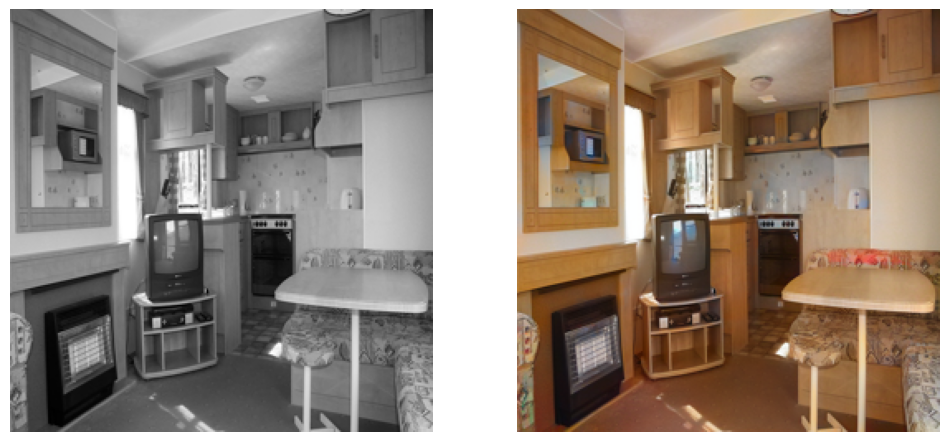

In [43]:
paths=glob.glob('./coco_sample/train_sample/*.jpg')
subset=np.random.choice(paths, 1, replace=False)
predict_output(model_36.net_G,subset[0])
# _,axes=plt.subplots(2,3,figsize=(10,10))
# for path in subset:
#     predict_output(final_model.net_G, subset)

# # print(subset)

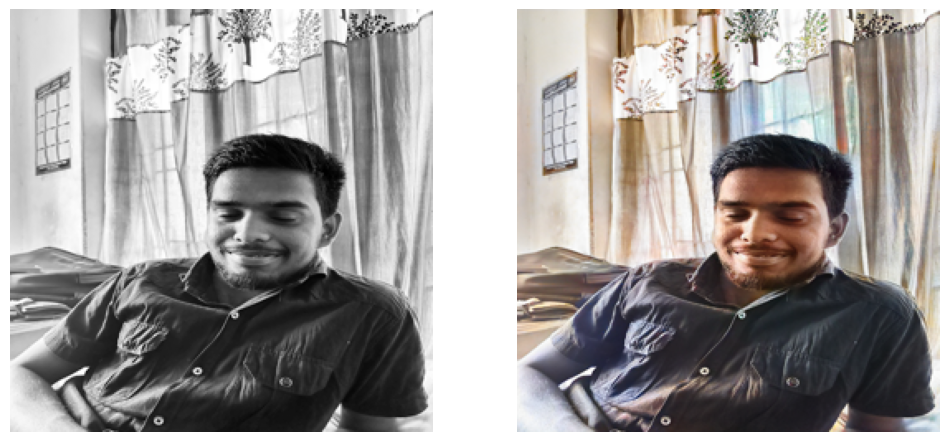

In [44]:
predict_output(model_36.net_G,'./mithundon.jpeg')

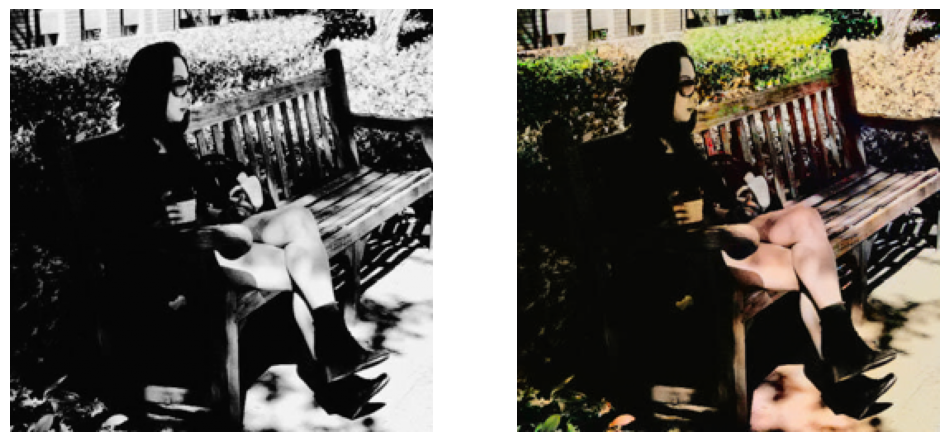

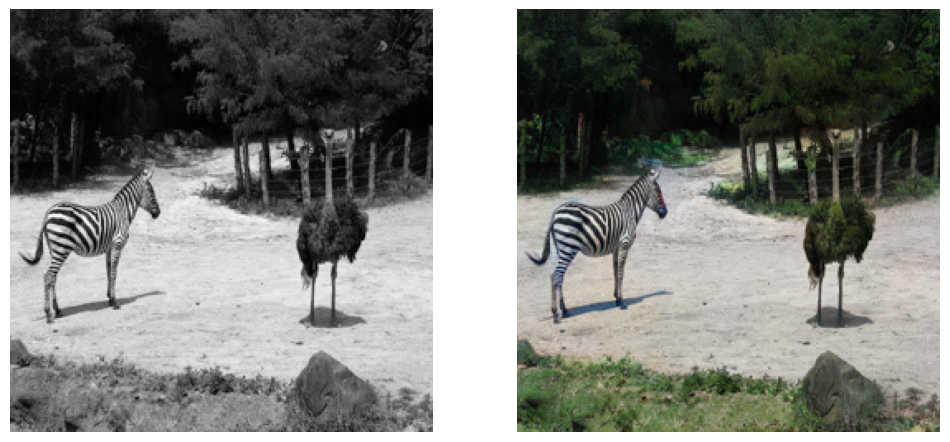

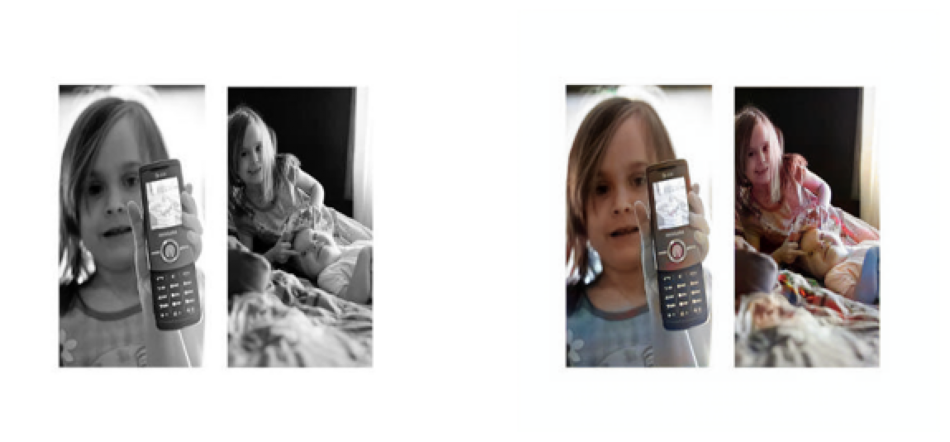

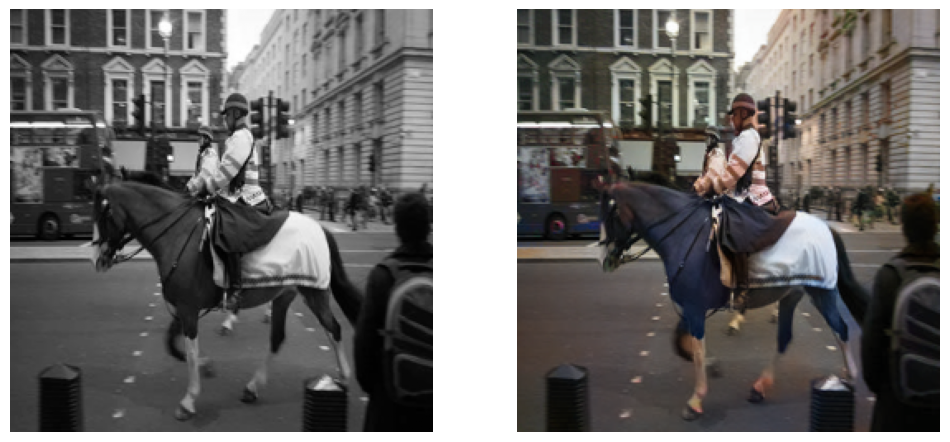

In [45]:
paths=glob.glob('./data/train_black/*.jpg')
subset=np.random.choice(paths, 4, replace=False)
# predict_output(net_G, path)
plt.figsize=(10,10)
for path in subset:
    predict_output(final_model.net_G, path)

In [26]:
from pathlib import Path

# Model path
MODEL_PATH = Path("GAN_models")
MODEL_NAME = "GeneratorModel.pth"

# Load the model
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load(MODEL_NAME,weights_only=True))

<All keys matched successfully>

In [28]:
model_with_pretrained_Gen= MainModel(net_G=net_G)
train_model(model_with_pretrained_Gen, train_dl,val_dl,2)

model initialized with norm initialization


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/2 Summary:
Training Losses:
  loss_D_fake: 1.7829		  loss_D_real: 1.3197		  loss_D: 1.5513		  loss_G_GAN: 1.4801		  loss_G_L1: 9.3722		  loss_G: 10.8523		  psnr_value: 19.1516		

Validation Losses:
  loss_D_fake: 2.3116		  loss_D_real: 2.0868		  loss_D: 2.1992		  loss_G_GAN: 0.9413		  loss_G_L1: 9.3142		  loss_G: 10.2555		  psnr_value: 19.9199		



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/2 Summary:
Training Losses:
  loss_D_fake: 0.8771		  loss_D_real: 0.9036		  loss_D: 0.8903		  loss_G_GAN: 0.8722		  loss_G_L1: 8.3138		  loss_G: 9.1860		  psnr_value: 19.9378		

Validation Losses:
  loss_D_fake: 0.8581		  loss_D_real: 0.8839		  loss_D: 0.8710		  loss_G_GAN: 0.8433		  loss_G_L1: 8.3946		  loss_G: 9.2379		  psnr_value: 19.8883		



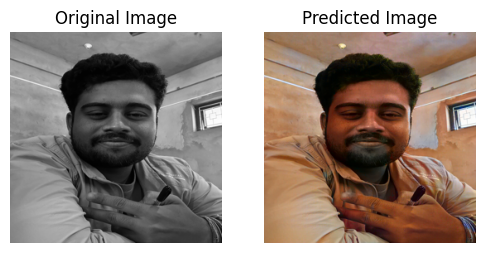

In [35]:
predict_output(scratch_model.net_G, "./nigam.jpeg")
# predict_output(net_G, "./project/image_colorization_datasets/subash_image.jpg")